# Bicing data cleaning
## The objective of this notebook
This notebook goes through the cleaning process of the Bicing usage dataset. 
You can find the source of the dataser here: https://opendata-ajuntament.barcelona.cat/data/en/dataset/estat-estacions-bicing

## What to achieve
The idea is to try to identify different trends on the behaviour of the stations during a regular day. Initially we suppose that stations will behave differently according to their location (is it a residencial station? Or an office one?). In order to do so we need to identify which data will help us answer this.

In [62]:
#Importing the required libraries
import pandas as pd
import seaborn as sns
import datetime as dt


In [63]:
octubre = pd.read_csv("..\\Dataset\\2019_10_Octubre_BicingNou_ESTACIONS.csv",encoding="utf_8")

In [64]:
#Checking how does the dataset look like
octubre.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3655823 entries, 0 to 3655822
Data columns (total 13 columns):
station_id                              int64
num_bikes_available                     int64
num_bikes_available_types.mechanical    int64
num_bikes_available_types.ebike         int64
num_docks_available                     int64
is_installed                            int64
is_renting                              int64
is_returning                            int64
last_reported                           float64
is_charging_station                     bool
status                                  object
last_updated                            int64
ttl                                     int64
dtypes: bool(1), float64(1), int64(10), object(1)
memory usage: 338.2+ MB


In [65]:
octubre.head()

,station_id,num_bikes_available,num_bikes_available_types.mechanical,num_bikes_available_types.ebike,num_docks_available,is_installed,is_renting,is_returning,last_reported,is_charging_station,status,last_updated,ttl
0,1,25,24,1,4,1,1,1,1.569881e+09,True,IN_SERVICE,1569880820,30
1,2,12,11,1,15,1,1,1,1.569881e+09,True,IN_SERVICE,1569880820,30
2,3,19,19,0,8,1,1,1,1.569881e+09,True,IN_SERVICE,1569880820,30
3,4,15,15,0,3,1,1,1,1.569881e+09,True,IN_SERVICE,1569880820,30
4,5,35,35,0,3,1,1,1,1.569881e+09,True,IN_SERVICE,1569880820,30


In [66]:
octubre.isnull().sum()

station_id                              0
num_bikes_available                     0
num_bikes_available_types.mechanical    0
num_bikes_available_types.ebike         0
num_docks_available                     0
is_installed                            0
is_renting                              0
is_returning                            0
last_reported                           0
is_charging_station                     0
status                                  0
last_updated                            0
ttl                                     0
dtype: int64

In [67]:
#We want the columns "last_reported" and "last_updated" to be datetime. At the moment they are values in Unix Epoch time.
#In order to transform it, we should change the type from float to integer, and then to string (we want to make sure no .0)
octubre.last_reported = octubre.last_reported.astype(int)
octubre.last_reported = octubre.last_reported.astype(str)
octubre.last_updated = octubre.last_updated.astype(str)
octubre.dtypes


station_id                               int64
num_bikes_available                      int64
num_bikes_available_types.mechanical     int64
num_bikes_available_types.ebike          int64
num_docks_available                      int64
is_installed                             int64
is_renting                               int64
is_returning                             int64
last_reported                           object
is_charging_station                       bool
status                                  object
last_updated                            object
ttl                                      int64
dtype: object

In [68]:
#Transforming from Unix Epoch time to datetime
octubre.last_reported = pd.to_datetime(octubre.last_reported, unit = 's')
octubre.last_updated = pd.to_datetime(octubre.last_updated, unit = 's')

In [69]:
#We play with a particular station, in this case the one I use from home, with id 381 [Each station has an id that can be
#found on the Bicing app.]
home = octubre.query('station_id== 381')

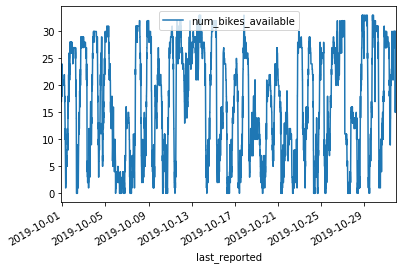

In [70]:
#Trying to visualize the number of bikes available per last_reported. It shows the whole month, which is not clear.
home_plot = home[["last_reported","num_bikes_available"]]
home_plot.plot(x='last_reported', y='num_bikes_available', style='-')

In [71]:
#We will check Ironhack's closest station and see how does it behave on a regular day.
ironhack = octubre[octubre['station_id'] == 211]
ih_bikes = ironhack[["last_reported","num_bikes_available"]]
ih_bikes["last_reported"] = ih_bikes["last_reported"].astype(str)
ih_bikes_day = ih_bikes[ih_bikes["last_reported"].str.startswith('2019-10-18')]

C:\Users\jaume\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


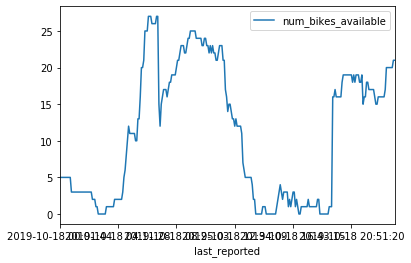

In [72]:
ih_bikes_day.plot(x='last_reported', y='num_bikes_available', style='-')

There are 4 moments of the day, on which two are busier and two the station is almost empty.

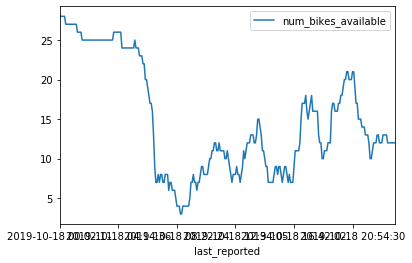

In [124]:
#By doing the same on the 'Home' station, which is initially a residential area, what do we see?
home = octubre.query('station_id== 381')
home_day = home_day[home_day.last_updated.dt.day == 18]
home_day.plot(x='last_reported', y='num_bikes_available', style='-')

There are three moments, a more full one at the very beginning of the day, a quick drop and emptier time during the day, and slowly gets more bikes towards the end of the day.

# Deleting unneeded columns 
We will initially need:
* Which station are we analyzing "station_id"
* How many bikes at the station "num_bikes_available"
* How many docks available "num_docks_available"
* We will check if "is_installed", "is_renting" and "is_returning" are actually relevant or if we can keep "status"
* We will keep only last_updated to as it seems to be the shared time between stations

- We will not distinguish between mechanical and ebikes at the moment.
- We will drop last_reported and is_charging_station at the moment-

In [74]:
octubre.head()

,station_id,num_bikes_available,num_bikes_available_types.mechanical,num_bikes_available_types.ebike,num_docks_available,is_installed,is_renting,is_returning,last_reported,is_charging_station,status,last_updated,ttl
0,1,25,24,1,4,1,1,1,2019-09-30 22:00:01,True,IN_SERVICE,2019-09-30 22:00:20,30
1,2,12,11,1,15,1,1,1,2019-09-30 21:59:14,True,IN_SERVICE,2019-09-30 22:00:20,30
2,3,19,19,0,8,1,1,1,2019-09-30 21:59:47,True,IN_SERVICE,2019-09-30 22:00:20,30
3,4,15,15,0,3,1,1,1,2019-09-30 21:58:23,True,IN_SERVICE,2019-09-30 22:00:20,30
4,5,35,35,0,3,1,1,1,2019-09-30 21:56:25,True,IN_SERVICE,2019-09-30 22:00:20,30


In [75]:
#Dropping initially unneeded columns
octubre.drop(columns=["num_bikes_available_types.mechanical","num_bikes_available_types.ebike","last_reported","is_charging_station"],inplace=True)

In [76]:
#Let's check values of 'status'
octubre.status.unique()

array(['IN_SERVICE', 'PLANNED', 'NOT_IN_SERVICE', 'MAINTENANCE'],
      dtype=object)

In [77]:
#At the moment, our most priority is to know if station is working or not. We will simplify this column using binary values
#0 will mean "is not working" and 1 will equal to 'IN_Service'

In [78]:
#We make a list of the 'not working' stations, and replace the values for a 0, do the same for 'IN_SERVICE' as 1
not_working = ['PLANNED', 'NOT_IN_SERVICE', 'MAINTENANCE']
octubre.replace(to_replace=not_working,value=0,inplace=True)
octubre.replace(to_replace='IN_SERVICE',value=1,inplace=True)

In [79]:
octubre.status.value_counts()

1    3618730
0      37093
Name: status, dtype: int64

In [44]:
#Now that we have all the columns as numbers, we can check their correlation and decide if we can drop
#is_installed, is_renting and is_returning

In [80]:
octubre.corr()

,station_id,num_bikes_available,num_docks_available,is_installed,is_renting,is_returning,status,ttl
station_id,1.000000,-0.003626,0.111034,-0.045797,-0.046471,-0.046468,-0.046468,-0.000017
num_bikes_available,-0.003626,1.000000,-0.829789,0.098514,0.104712,0.104709,0.104709,0.002220
num_docks_available,0.111034,-0.829789,1.000000,-0.079638,-0.073274,-0.073272,-0.073272,-0.002256
is_installed,-0.045797,0.098514,-0.079638,1.000000,0.940810,0.940836,0.940836,-0.000099
is_renting,-0.046471,0.104712,-0.073274,0.940810,1.000000,0.999973,0.999973,-0.000036
is_returning,-0.046468,0.104709,-0.073272,0.940836,0.999973,1.000000,1.000000,-0.000043
status,-0.046468,0.104709,-0.073272,0.940836,0.999973,1.000000,1.000000,-0.000043
ttl,-0.000017,0.002220,-0.002256,-0.000099,-0.000036,-0.000043,-0.000043,1.000000


We see how 'status' is very correlated with 'is installed', 'is_renting' and 'is_returning' for this reason it makes no sense to keep them all 4 and we can consider 'status' as the one that defines if the station is working or not.

In [81]:
octubre.drop(columns=["is_installed","is_renting","is_returning"],inplace=True)

In [82]:
octubre.head()

,station_id,num_bikes_available,num_docks_available,status,last_updated,ttl
0,1,25,4,1,2019-09-30 22:00:20,30
1,2,12,15,1,2019-09-30 22:00:20,30
2,3,19,8,1,2019-09-30 22:00:20,30
3,4,15,3,1,2019-09-30 22:00:20,30
4,5,35,3,1,2019-09-30 22:00:20,30


In [83]:
#We will keep 'ttl' as number of docks in the station just in case we decide to play with % in the future.

# How do we manage time?

In [85]:
#There are 8916 total different timeframes at the moment
len(octubre.last_updated.value_counts())

8916

In [86]:
#We are seeing the dataset contains value from September, we will delete that
octubre.last_updated.head()

0   2019-09-30 22:00:20
1   2019-09-30 22:00:20
2   2019-09-30 22:00:20
3   2019-09-30 22:00:20
4   2019-09-30 22:00:20
Name: last_updated, dtype: datetime64[ns]

In [116]:
octubre = octubre[octubre.last_updated.dt.month == 10]

In [118]:
octubre.head()

,station_id,num_bikes_available,num_docks_available,status,last_updated,ttl
10250,1,27,2,1,2019-10-01 00:05:10,20
10251,2,12,15,1,2019-10-01 00:05:10,20
10252,3,18,9,1,2019-10-01 00:05:10,20
10253,4,14,4,1,2019-10-01 00:05:10,20
10254,5,36,2,1,2019-10-01 00:05:10,20


In [121]:
octubre.to_csv("..\\Dataset\\October_cleaned.csv",encoding="utf_8")